# Imports

In [ ]:
!pip install -U vit-keras

In [ ]:
pip install -U tensorflow-addons

In [ ]:
import os
import random
from datetime import datetime
import numpy as np
import keras 
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from vit_keras import vit

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  6 18:33:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 50
CLASSES = ["Normal", "Stroke"]

In [ ]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Model Setup

In [ ]:
import os

DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

path, dirs, files = next(os.walk(DF_TRAIN + "/Stroke"))
file_count = len(files)
print('Stroke:', file_count)
path, dirs, files = next(os.walk(DF_TRAIN + "/Normal"))
file_count = len(files)
print('Non-Stroke:', file_count)

Stroke: 825
Non-Stroke: 1426


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# images generator
# train_gen = ImageDataGenerator(rescale = 1./255,
#                                validation_split = 0.2) 
# test_gen = ImageDataGenerator(rescale = 1./255)

train_gen = ImageDataGenerator(validation_split = 0.2)
test_gen  = ImageDataGenerator()

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                          )

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE)
                                         )

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


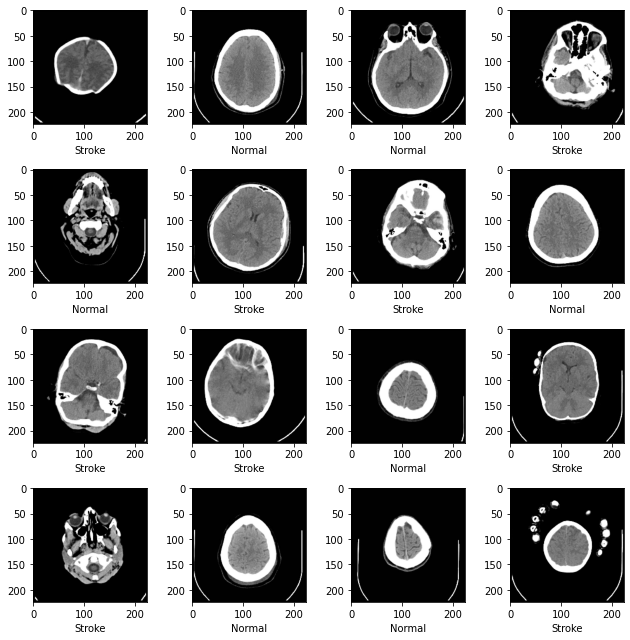

In [ ]:
# show images from dataset
import matplotlib.pyplot as plt

images, labels = next(test_set)[:16]
labels = labels.argmax(axis=1)
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.astype("uint8"))
    ax.set_xlabel(CLASSES[label.astype(int)])
plt.tight_layout()
plt.show()

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# Manifold Learning

## Auxiliar Functions

In [ ]:
import matplotlib.pyplot as plt

def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = tf.keras.models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)

def print2D(embedding, title):
  plt.figure(figsize=[25,10])
  plt.scatter(
      embedding[:, 0],
      embedding[:, 1])
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24)
  plt.show()

def print3D(embedding, title, labels):
  fig = plt.figure(figsize=[25,10])
  ax = plt.axes(projection ="3d")
  p = ax.scatter(
      embedding[:, 0],
      embedding[:, 1],
      embedding[:, 2],
      c = labels
  )
  plt.title(title, fontsize=24)
  fig.colorbar(p,boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

**LLE**

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

def lle(model, dataset, feature=True):
  embeddingLLE = LocallyLinearEmbedding(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresLLE = embeddingLLE.fit_transform(Y_pred)
  return featuresLLE

**Isomap**

In [ ]:
from sklearn.manifold import Isomap

def isomap(model, dataset, feature=True):
  embeddingIsomap = Isomap(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresIsomap = embeddingIsomap.fit_transform(Y_pred)
  return featuresIsomap

**t-SNE**

In [ ]:
from sklearn.manifold import TSNE

def tsne(model, dataset, feature=True):
  embeddingTSNE = TSNE(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresTSNE = embeddingTSNE.fit_transform(Y_pred)
  return featuresTSNE

**uMAP**

In [ ]:
!pip install umap-learn[plot]

     |████████████████████████████████| 86 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 7.3 MB/s 
     |████████████████████████████████| 15.8 MB 19.3 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |████████████████████████████████| 132 kB 76.3 MB/s 
     |████████████████████████████████| 802 kB 22.5 MB/s 
     |████████████████████████████████| 793 kB 85.2 MB/s 
     |████████████████████████████████| 793 kB 60.8 MB/s 
     |████████████████████████████████| 791 kB 74.9 MB/s 
     |████████████████████████████████| 786 kB 74.5 MB/s 
     |████████████████████████████████| 779 kB 74.8 MB/s 
     |████████████████████████████████| 778 kB 72.0 MB/s 
     |████████████████████████████████| 776 kB 84.4 MB/s 
     |████████████████████████████████| 769 kB 26.8 MB/s 
     |████████████████████████████████| 766 kB 77.2 MB/s 
     |████████████████████████████████| 1.0 MB 74.3 MB/s 
     |████████████████████████████████| 722 kB 87.6 MB/s 
     |████████████

In [ ]:
import umap

def uMAP(model, dataset, feature=True):
  embeddingUMAP = umap.UMAP(n_components=3)
  model_len = len(model.layers)
  model_top_len = 0
  if (feature):
    model_top_len = 4
  out_model = tf.keras.models.Model(inputs  = model.input,
                                    outputs = model.layers[model_len - model_top_len].output)
  Y_pred = out_model.predict(dataset)

  featuresUMAP = embeddingUMAP.fit_transform(Y_pred)
  return featuresUMAP

## Manifold Tests

In [ ]:
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.efficientnet import preprocess_input

eff_model = EfficientNetB2(weights='imagenet', include_top=False)

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

eff_feature = eff_model.predict(img_data)

print(eff_feature.shape)

In [ ]:
Y_pred = eff_model.predict(valid_set)

eff_feature_list = []

for y_pred in Y_pred:
  eff_feature_np = np.array(y_pred)
  eff_feature_list.append(eff_feature_np.flatten())

eff_feature_list_np = np.array(eff_feature_list)

In [ ]:
from sklearn.manifold import Isomap
embeddingIsomap = Isomap(n_components=3)

In [ ]:
embeddingIsomapFeat = embeddingIsomap.fit_transform(eff_feature_list_np)

In [ ]:
print2D(embeddingIsomapFeat, "ISOMAP projection of the dataset")

In [ ]:
print3D(embeddingIsomapFeat, "ISOMAP projection of the dataset", valid_set)

# EfficientNetB2

## Build Model

In [ ]:
# create EfficientNetB2 base model
base_model = tf.keras.applications.EfficientNetB2(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')                                                                   
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(2, activation = 'sigmoid', name = 'Final')(x)
model_effnet = tf.keras.models.Model(name = "efficientnetb2", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_effnet.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

In [ ]:
model_effnet.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 224, 224, 3)  0           ['input_17[0][0]']               
                                                                                                  
 normalization_16 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_16[0][0]']           
 n)                                                                                               
                                                                                     

## Train Model

In [ ]:
# train the model
from datetime import datetime

start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('efficientnetb2')
history = model_effnet.fit(train_set,
                           epochs = EPOCHS,
                           validation_data = valid_set,
                           callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-06 21:20:08.562604
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


113/113 [==============================] - ETA: 0s - loss: 0.5184 - tp: 1339.0000 - fp: 449.0000 - tn: 1352.0000 - fn: 462.0000 - BinaryAccuracy: 0.7428 - precision: 0.7489 - recall: 0.7435 - auc: 0.8275
Epoch 00001: val_loss improved from inf to 1.79129, saving model to model.efficientnetb2.h5
113/113 [==============================] - 50s 334ms/step - loss: 0.5184 - tp: 1339.0000 - fp: 449.0000 - tn: 1352.0000 - fn: 462.0000 - BinaryAccuracy: 0.7428 - precision: 0.7489 - recall: 0.7435 - auc: 0.8275 - val_loss: 1.7913 - val_tp: 251.0000 - val_fp: 196.0000 - val_tn: 254.0000 - val_fn: 199.0000 - val_BinaryAccuracy: 0.5611 - val_precision: 0.5615 - val_recall: 0.5578 - val_auc: 0.5873 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.3081 - tp: 1590.0000 - fp: 213.0000 - tn: 1588.0000 - fn: 211.0000 - BinaryAccuracy: 0.8823 - precision: 0.8819 - recall: 0.8828 - auc: 0.9427
Epoch 00002: val_loss improved from 1.79129 to 1.53360, saving model to model.

In [ ]:
!cp '/content/model.efficientnetb2.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.efficientnetb2.h5'

## Evaluate Model

In [ ]:
# get results
results = model_effnet.evaluate(test_set, steps = len(test_set), verbose = 1, return_dict = True)

16/16 [==============================] - 2s 106ms/step - loss: 2.1185 - tp: 177.0000 - fp: 73.0000 - tn: 177.0000 - fn: 73.0000 - BinaryAccuracy: 0.7080 - precision: 0.7080 - recall: 0.7080 - auc: 0.7562


In [ ]:
# show results
print('EfficientNetB2:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

EfficientNetB2:
---------------
ACCURACY: 0.708
Binary Accuracy: 0.7080000042915344
Precision: 0.7080000042915344
Recall: 0.7080000042915344
AUC: 0.7562479972839355
F1 Score: 0.7080000042915344


## Predict

[0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0]

Classification Report
              precision    recall  f1-score   support

      Normal       0.80      0.80      0.80        10
      Stroke       0.80      0.67      0.73         6

   micro avg       0.80      0.75      0.77        16
   macro avg       0.80      0.73      0.76        16
weighted avg       0.80      0.75      0.77        16
 samples avg       0.75      0.75      0.75        16

Confusion Matrix
[[9 1]
 [2 4]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


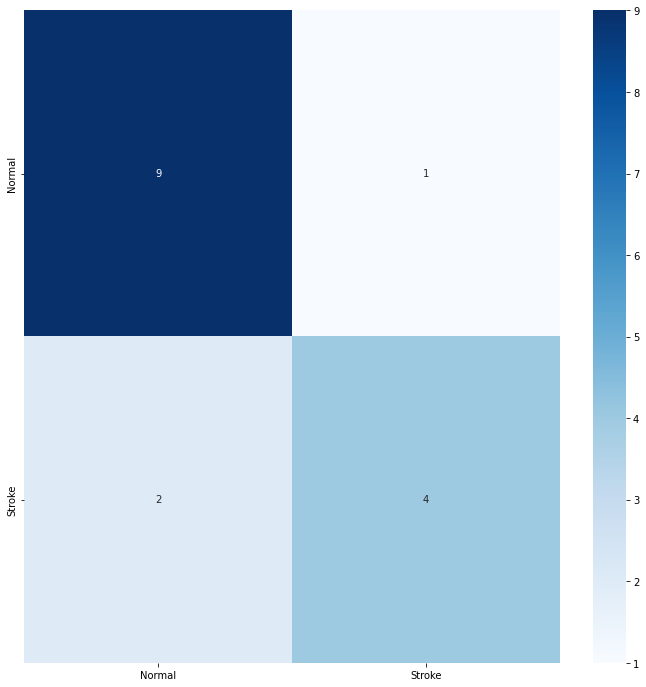

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

images, labels = next(test_set)

Y_pred = model_effnet.predict(images)
y_pred = (Y_pred > 0.8).astype("int32")

print(y_pred.argmax(axis=1))
print(labels.argmax(axis=1))

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(labels, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(labels.argmax(axis=1), y_pred.argmax(axis=1))
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

In [ ]:
marks = [65, 71, 68, 74, 61]

it = iter(marks)
done_looping = False
while not done_looping:
  try:
    item = next(it)
    print(item)
  except StopIteration:
    done_looping = True

65
71
68
74
61


In [ ]:
# test_set.reset()
# images, labels = test_set.next()
# print(test_set.batch_index)
# images, labels = test_set.next()
# print(test_set.batch_index)

# index of file inside array
print(test_set.index_array)

# index of batch of filtes
print(test_set.batch_index)

# size of samples
print(test_set.samples)
print(test_set.classes)

[191 240 121 190 222 118 239  64  28   6 229  21 210 206  94  63 189  20
 175  43 152 114 249  41  67 112  97  91  10 179 248 185 209 201 108 231
 153 138 139  78  86  75 164  19 195  79 149 168 127 159 169  96  87 133
 145 207 202   9 225 235 128  68  82  72  80 214  22 171  39 241 109  38
   0 144  56 126 117 180 111 132 150 244  54 120 198  71 204  66 134 107
  74  61  81 242 197  11 203  13 119  42  14 212  23  55 130 196 160 188
 100 193 247 218  44 174 192 238 116  32   7  85 182 103  62 142 199 226
 217  69  93 113 236 148 135 157  37  57 143 125  29  30  50 104 170 187
 246 124  35  33  99 137   5  25 146 194 154 216 156 232 140 200 221 131
  24 106  58  36 155  52 151  17 162  88 220 227  48  46  47 172 147 136
 237  27  49 245  26 141  34 234 186  89  73 230 101  59  31 122  15 223
  83  95  84  16  76 233 181   2  45 228 183 129 123  98 177   3  70 166
 110 105 224  65  60  40 184 115   8 161 205  53 173 243 219 165  18   1
 176 167  77 208  92 215  51 211 178 102 158  12   

In [ ]:
test_set.reset()
batchX, batchy = valid_set.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print(batchy)

batchX, batchy = valid_set.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print(batchy)

**LLE**

In [ ]:
featuresLLE = lle(model_effnet, valid_set)
print2D(featuresLLE, "LLE projection of the dataset")
print3D(featuresLLE, "LLE projection of the dataset", valid_set)

ValueError: ignored

**Isomap**

In [ ]:
# embeddingIsomap = Isomap(n_components=3)
# model_len = len(model_effnet.layers)
# model_top_len = 4
# out_model = tf.keras.models.Model(inputs  = model_effnet.input,
#                                   outputs = model_effnet.layers[model_len - model_top_len].output)

# Y_pred_Isomap = out_model.predict(images)
# nsamples, nx, ny, nz = Y_pred_Isomap.shape
# X_train_Isomap = Y_pred_Isomap.reshape(nsamples,nx*ny*nz)

# featuresIsomap = embeddingIsomap.fit_transform(X_train_Isomap)

embeddingIsomap = Isomap(n_components=3)
model_len = len(model_effnet.layers)
model_top_len = 4
out_model = tf.keras.models.Model(inputs  = model_effnet.input,
                                  outputs = model_effnet.layers[model_len - model_top_len].output)

Y_pred_Isomap = out_model.predict(valid_set)
nsamples, nx, ny, nz = Y_pred_Isomap.shape
X_train_Isomap = Y_pred_Isomap.reshape(nsamples,nx*ny*nz)

featuresIsomap = embeddingIsomap.fit_transform(X_train_Isomap)

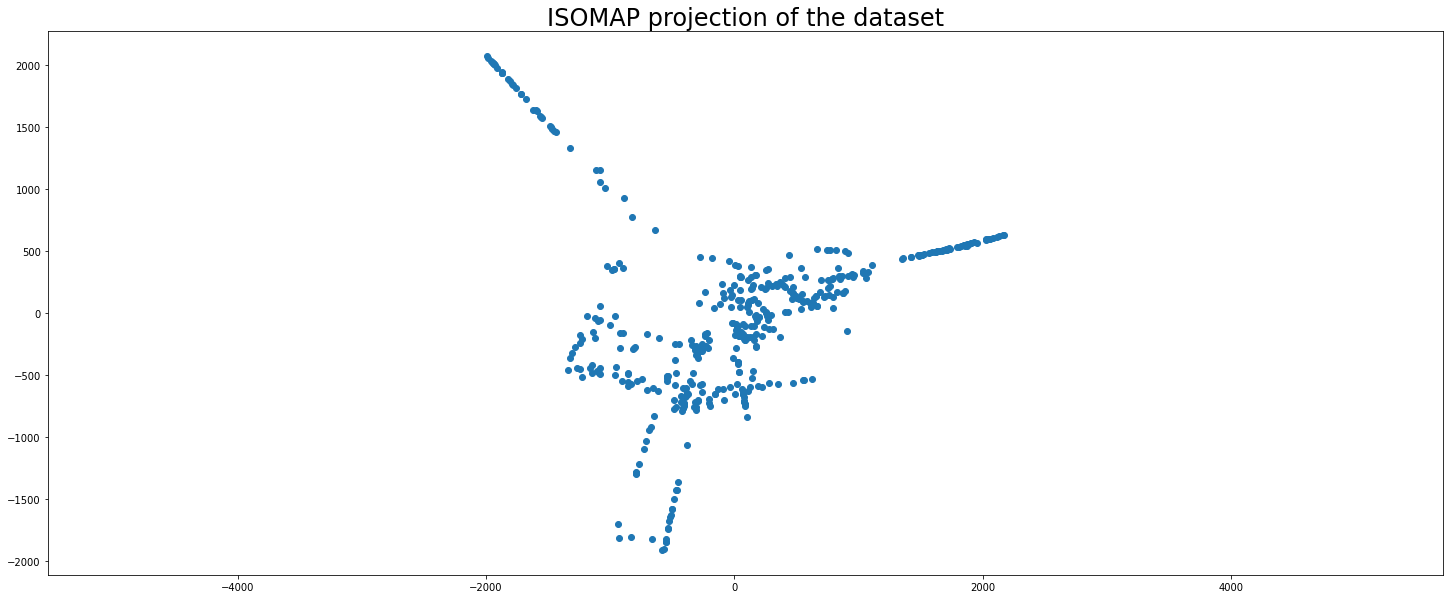

In [ ]:
print2D(featuresIsomap, "ISOMAP projection of the dataset")

KeyboardInterrupt: ignored

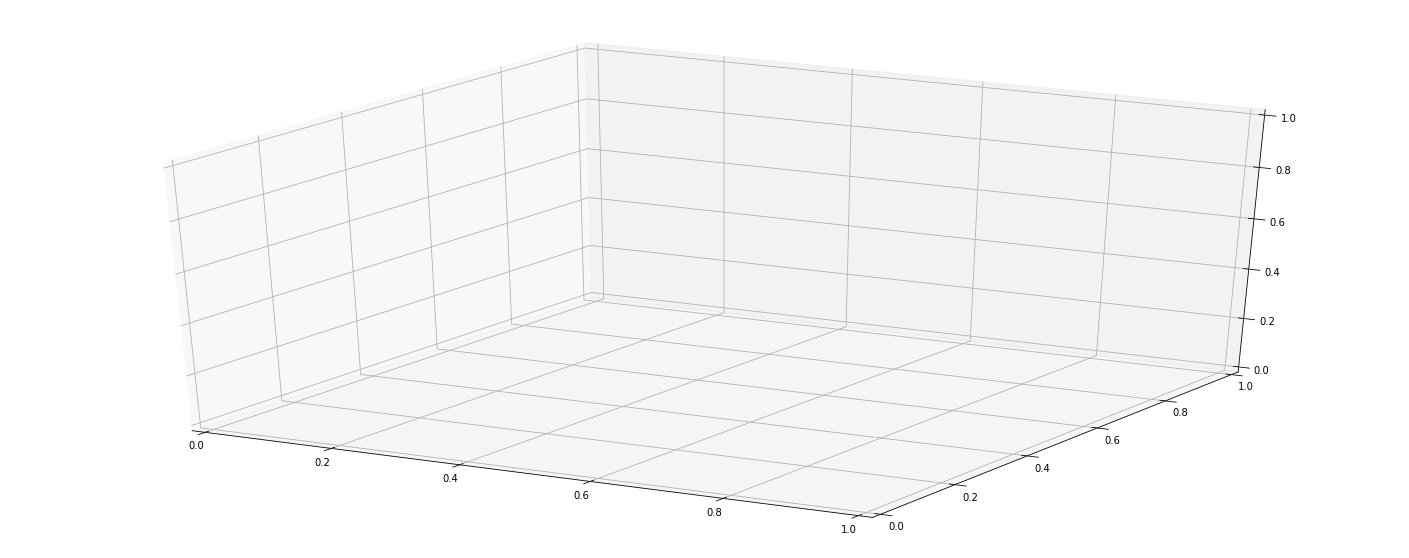

In [ ]:
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

In [ ]:
featuresIsomap = isomap(model_effnet, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

ValueError: ignored

**t-SNE**

In [ ]:
featuresTSNE = tsne(eff_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

In [ ]:
featuresUMAP = uMAP(eff_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)

# ViT B16

## Build Model

In [ ]:
IMAGE_SIZE = 224

# build vit model with 16 patch_size
base_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

vit_features = base_model.output
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate=.45, seed = 123)(x)        
predictions = Dense(1, activation = 'sigmoid')(x)
vit_model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

vit_model.summary()

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

vit_model.compile(loss = 'binary_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
                  metrics = metrics)

# model.compile(loss = 'binary_crossentropy', 
#               optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
#               metrics = metrics)

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb16')
history = vit_model.fit(train_set,
                        epochs = NUM_EPOCHS,
                        validation_data = valid_set,
                        callbacks = [callbacks])

end = datetime.now()
print(end-start)

In [ ]:
!cp '/content/model.vitb16.h5' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/weights/model.vitb16.h5'

## Evaluate Model

In [ ]:
# get results
results = vit_model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

In [ ]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

## Predict

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = vit_model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

**LLE**

In [ ]:
featuresLLE = lle(vit_model, valid_set)
print2D(featuresLLE, "LLE projection of the dataset")
print3D(featuresLLE, "LLE projection of the dataset", valid_set)

**Isomap**

In [ ]:
featuresIsomap = isomap(vit_model, valid_set)
print2D(featuresIsomap, "ISOMAP projection of the dataset")
print3D(featuresIsomap, "ISOMAP projection of the dataset", valid_set)

**t-SNE**

In [ ]:
featuresTSNE = tsne(vit_model, valid_set)
print2D(featuresTSNE, "t-SNE projection of the dataset")
print3D(featuresTSNE, "t-SNE projection of the dataset", valid_set)

**uMAP**

In [ ]:
featuresUMAP = uMAP(vit_model, valid_set)
print2D(featuresUMAP, "uMAP projection of the dataset")
print3D(featuresUMAP, "uMAP projection of the dataset", valid_set)